# N26 Data Scientist Code Task
## Kyryl Yelizarov

##### Motivation
N26 relies on insights generated from customer data to offer users access to the best banking products possible and
the greatest level of insight into their own finances. One recurring need is to assess user creditworthiness & offer
customers predictions of how well off they will be financially in future months based on their current transactions.

##### Task
Predict income and expenses for a holdout sample of ~10k users for the month of August based on a training sample
of ~10k users from February through July. Based your judgement of the usefulness of the results, either aggregate
the data into incoming & outgoing flows, or predict based on the transaction type / category level.

All research was developed using Python. Next you can find Jupyter notebook with description of performed steps 

First of all we import necessary packages:
 * pandas
 * numpy
 * sklearn
 * matplotlib
 * seaborn


In [1]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

Data for the research was put into data folder. Data libraray consists of three files:
 * 2016-09-19_79351_training.csv
 * mcc_group_definition.csv
 * transaction_types.csv
 
Let's read them

In [2]:
train = pd.read_csv('data/2016-09-19_79351_training.csv', na_values='NA')
mcc_group = pd.read_csv('data/mcc_group_definition.csv')
tran_types = pd.read_csv('data/transaction_types.csv')

First look on our data sets. 

In [3]:
print("2016-09-19_79351_training.csv read into Dataframe train shape of {0}".format(train.shape))
print(train.head())
print("\n mcc_group_definition.csv read into Dataframe mcc_group shape of {0}".format(mcc_group.shape))
print(mcc_group.head())
print("\n transaction_types.csv read into Dataframe tran_types shape of {0}".format(tran_types.shape))
print(tran_types.head())

2016-09-19_79351_training.csv read into Dataframe train shape of (408546, 7)
                            user_id transaction_date transaction_type  \
0  a78884f5e76951188c1e719d4956773a       2016-02-01               DT   
1  b0333294fef6ff1299102a70ad46b126       2016-02-01               DT   
2  7b8d2a2780adae0cd0c248e92c1b28dc       2016-02-01               DT   
3  cc4abaa500f7db4390ae3f02bd36d805       2016-02-01               DT   
4  49b99d1d5ba028566639e8b3eb7c055b       2016-02-01               DT   

   mcc_group  amount_n26_currency dataset_transaction dataset_user  
0        NaN                  350            training     training  
1        NaN                  202            training     training  
2        NaN                  291            training     training  
3        NaN                  214            training     training  
4        NaN                  272            training     training  

 mcc_group_definition.csv read into Dataframe mcc_group shape of (17,

We can see that in last two data sets is information about transaction types and MCC groups. 
On train data set we can see two last strange columns - let's look what in them:

In [4]:
print(train['dataset_transaction'].value_counts())
print(train['dataset_user'].value_counts())

training    408546
Name: dataset_transaction, dtype: int64
training    408546
Name: dataset_user, dtype: int64


It's clear that *dataset_transaction* and *dataset_user* are technical columns which were used for building datasets. We can get rid of them in future analysis.

Now we will merge explanation from lookup datasets to main one.

In [5]:
train_full = pd.merge(train, mcc_group, how='left', on='mcc_group')
train_full = train_full.rename(columns={'explanation': 'expl_mcc'})
train_full = pd.merge(train_full, tran_types, how='left', left_on='transaction_type', right_on='type')
train_full = train_full.rename(columns={'explanation': 'expl_trans'})
train_full = train_full.drop(['type', 'dataset_transaction', 'dataset_user'], axis=1)

# check that join didn't change number of records
assert (train.shape[0] == train_full.shape[0])

print(train_full.info())
print(train_full['transaction_type'].value_counts())
print(train_full['mcc_group'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 9 columns):
user_id                408546 non-null object
transaction_date       408546 non-null object
transaction_type       408546 non-null object
mcc_group              258324 non-null object
amount_n26_currency    408546 non-null int64
expl_mcc               258324 non-null object
expl_trans             408546 non-null object
direction              408546 non-null object
agent                  408546 non-null object
dtypes: int64(1), object(8)
memory usage: 31.2+ MB
None
PT     258324
CT      63837
DT      40528
DD      29869
FT       6528
DR       4727
BBU      3561
BUB       942
TUB       230
Name: transaction_type, dtype: int64
1.0     69807
2.0     50586
6.0     24672
3.0     20875
8.0     20610
4.0     20194
17.0    11466
16.0    11150
7.0     10888
10.0     7282
11.0     5803
5.0      3337
12.0      873
15.0      329
9.0       287
13.0      141
14.0       24
Name: mcc_group, dty

We can see that in 36.77% of cases mcc_group field have NA value in train data set. Also not all transaction codes which are described in transaction_types dataset occure in train dataset.

### Target variable preparation
In the task was noted that we should predict incoming ang outcoming flows of money but predicting tham separately isn't very good idea because they are hihgly connected. If client doesn't have money he won't have money to spent.
In transaction type dataset we have field *direction* which shows if it's incoming or outcoming flow. As the first step  of creation *target* variable there was decided to nultuply outgoing flows on -1.

In [6]:
def target_builder(row):
    target = row['amount_n26_currency']
    if row['transaction_type'] == 'AR':
        target = 0
    elif row['direction'] == 'In':
        target = row['amount_n26_currency']
    elif row['direction'] == 'Out':
        target = -1 * row['amount_n26_currency']
    return target


train_full['target'] = train_full.apply(target_builder, axis=1)


As the prediction needed to be done for all month, so from transaction field, there was built variable which indicates month and year of transaction.

Also built small summary summary table of amount of money going In and Out:

In [7]:
train_full['month'] = pd.to_datetime(train_full['transaction_date']).dt.strftime('%Y-%m')

train_full.groupby(['direction']).agg({'user_id': 'count', 'target': ['sum', 'mean']})

user_id    target            
            count       sum        mean
direction                              
In          72125  10023119  138.968721
Out        336421 -11533469  -34.282845

As all independent fields are class variables, so there was decided to build dummy variables. 

In [8]:
train_full['agent'] = train_full['agent'].replace(' ', '_', regex=True)
train_full = train_full.join(pd.get_dummies(train_full[['transaction_type', 'agent', 'mcc_group']], dummy_na=True, drop_first=True))

Full information of dataset:

In [9]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408546 entries, 0 to 408545
Data columns (total 40 columns):
user_id                 408546 non-null object
transaction_date        408546 non-null object
transaction_type        408546 non-null object
mcc_group               258324 non-null object
amount_n26_currency     408546 non-null int64
expl_mcc                258324 non-null object
expl_trans              408546 non-null object
direction               408546 non-null object
agent                   408546 non-null object
target                  408546 non-null int64
month                   408546 non-null object
transaction_type_BUB    408546 non-null uint8
transaction_type_CT     408546 non-null uint8
transaction_type_DD     408546 non-null uint8
transaction_type_DR     408546 non-null uint8
transaction_type_DT     408546 non-null uint8
transaction_type_FT     408546 non-null uint8
transaction_type_PT     408546 non-null uint8
transaction_type_TUB    408546 non-null uint8
transa

Let's look on distribution of average In/Out flow by month:

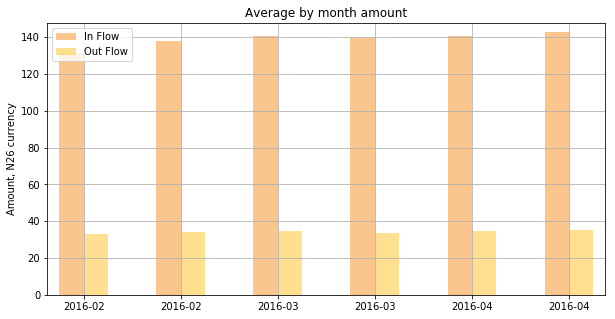

In [10]:
df = train_full.groupby(['month', 'direction']).agg({'amount_n26_currency': 'mean'})
df = df.reset_index()

pos = list(range(len(df['month'].unique()))) 
width = 0.25 
    
fig, ax = plt.subplots(figsize=(10, 5))

plt.bar(pos, df.loc[df['direction'] == 'In', 'amount_n26_currency'], width, alpha=0.5, color='#F78F1E') 
plt.bar([p + width for p in pos], df.loc[df['direction'] == 'Out', 'amount_n26_currency'], width, alpha=0.5, color='#FFC222') 

ax.set_ylabel('Amount, N26 currency')
ax.set_title('Average by month amount')

ax.set_xticks([p + 0.5 * width for p in pos])
ax.set_xticklabels(df['month'])

plt.xlim(min(pos)-width, max(pos)+width*2)
plt.ylim([0, max(df['amount_n26_currency'])+5] )

plt.legend(['In Flow', 'Out Flow'], loc='upper left')
plt.grid()
plt.show()
plt.show()


As we can see on the bar plot - there is no big difference between month average In and Out flows.

Let's look at distribution of average amount by transaction type:

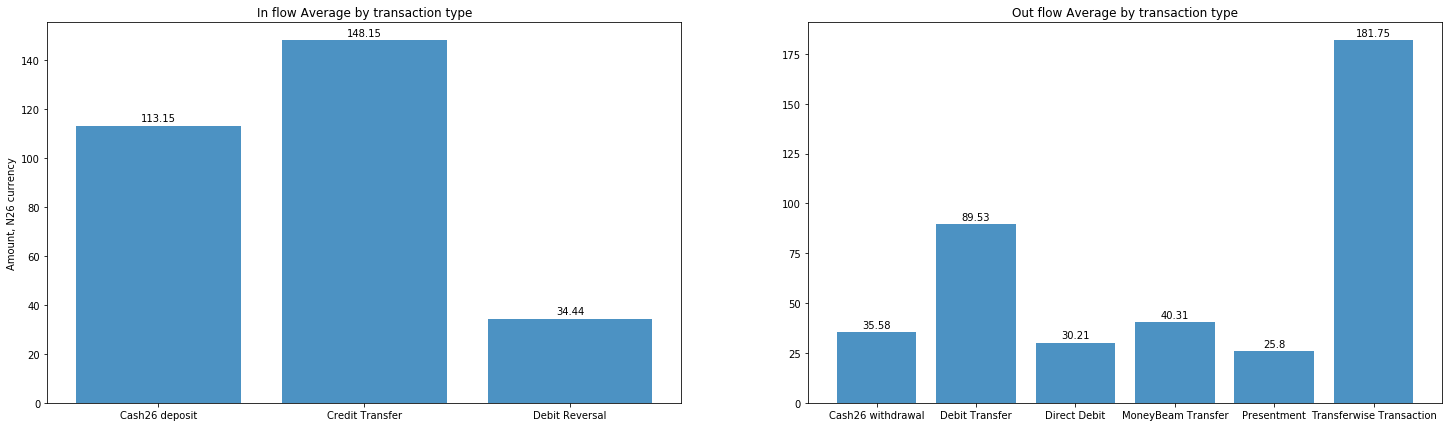

In [11]:
df = train_full.groupby(['expl_trans', 'direction']).agg({'amount_n26_currency': 'mean'})
df = df.reset_index()
  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))

ax1.bar(df.loc[df['direction'] == 'In', 'expl_trans'], df.loc[df['direction'] == 'In', 'amount_n26_currency'], alpha=0.8)
ax2.bar(df.loc[df['direction'] == 'Out', 'expl_trans'], df.loc[df['direction'] == 'Out', 'amount_n26_currency'], alpha=0.8) 

ax1.set_ylabel('Amount, N26 currency')
ax1.set_title('In flow Average by transaction type')
ax2.set_title('Out flow Average by transaction type')

ax1.set_xticklabels(df.loc[df['direction'] == 'In', 'expl_trans'])
ax2.set_xticklabels(df.loc[df['direction'] == 'Out', 'expl_trans'])

rects = ax1.patches
labels = df.loc[df['direction'] == 'In', 'amount_n26_currency'].apply(lambda x: round(x, 2)).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom')

rects = ax2.patches
labels = df.loc[df['direction'] == 'Out', 'amount_n26_currency'].apply(lambda x: round(x, 2)).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom')

plt.show()

The most average In flow is created by *Credit Transfer* and *Cash26 deposit*. Out flow is mainly created by *Transferwise Transactions*.

Let's look at same distribution but by agent:

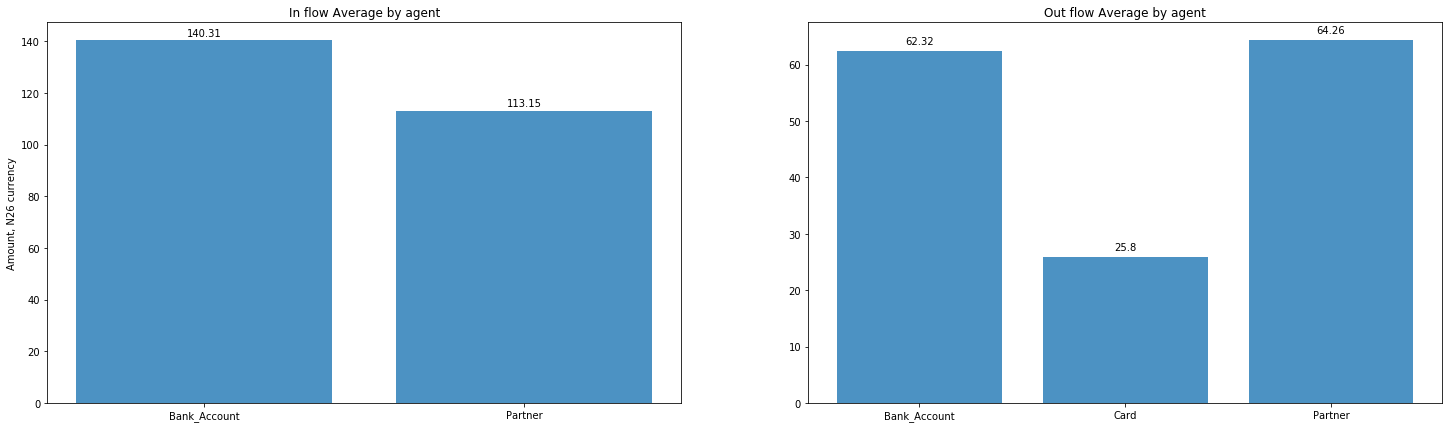

In [12]:
df = train_full.groupby(['agent', 'direction']).agg({'amount_n26_currency': 'mean'})
df = df.reset_index()
  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))

ax1.bar(df.loc[df['direction'] == 'In', 'agent'], df.loc[df['direction'] == 'In', 'amount_n26_currency'], alpha=0.8)
ax2.bar(df.loc[df['direction'] == 'Out', 'agent'], df.loc[df['direction'] == 'Out', 'amount_n26_currency'], alpha=0.8) 

ax1.set_ylabel('Amount, N26 currency')
ax1.set_title('In flow Average by agent')
ax2.set_title('Out flow Average by agent')

ax1.set_xticklabels(df.loc[df['direction'] == 'In', 'agent'])
ax2.set_xticklabels(df.loc[df['direction'] == 'Out', 'agent'])

rects = ax1.patches
labels = df.loc[df['direction'] == 'In', 'amount_n26_currency'].apply(lambda x: round(x, 2)).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom')

rects = ax2.patches
labels = df.loc[df['direction'] == 'Out', 'amount_n26_currency'].apply(lambda x: round(x, 2)).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom')

plt.show()

Both for In and Out flow *Bank Account* generates the biggest flow.

Next let's look what for clients are spending their money most for in average.

                                      amount_n26_currency
expl_mcc                   direction                     
ATM                        Out                  43.758563
Automotive/Gas             Out                  16.138865
Business Expenses          Out                  30.911303
Drugstore                  Out                  13.386352
Education                  Out                  56.498480
Entertainment/Leisure      Out                  14.399066
Family/Babies/Children     Out                  22.846690
Finance                    Out                  70.376861
Gastronomie                Out                  12.153916
Groceries                  Out                  11.009785
Home and DIY, House Energy Out                  35.231645
Insurance                  Out                  33.950355
Miscellaneous              Out                  23.189058
Shopping/(Fashion)         Out                  24.794196
Taxes and Fines            Out                  28.625000
Transport     

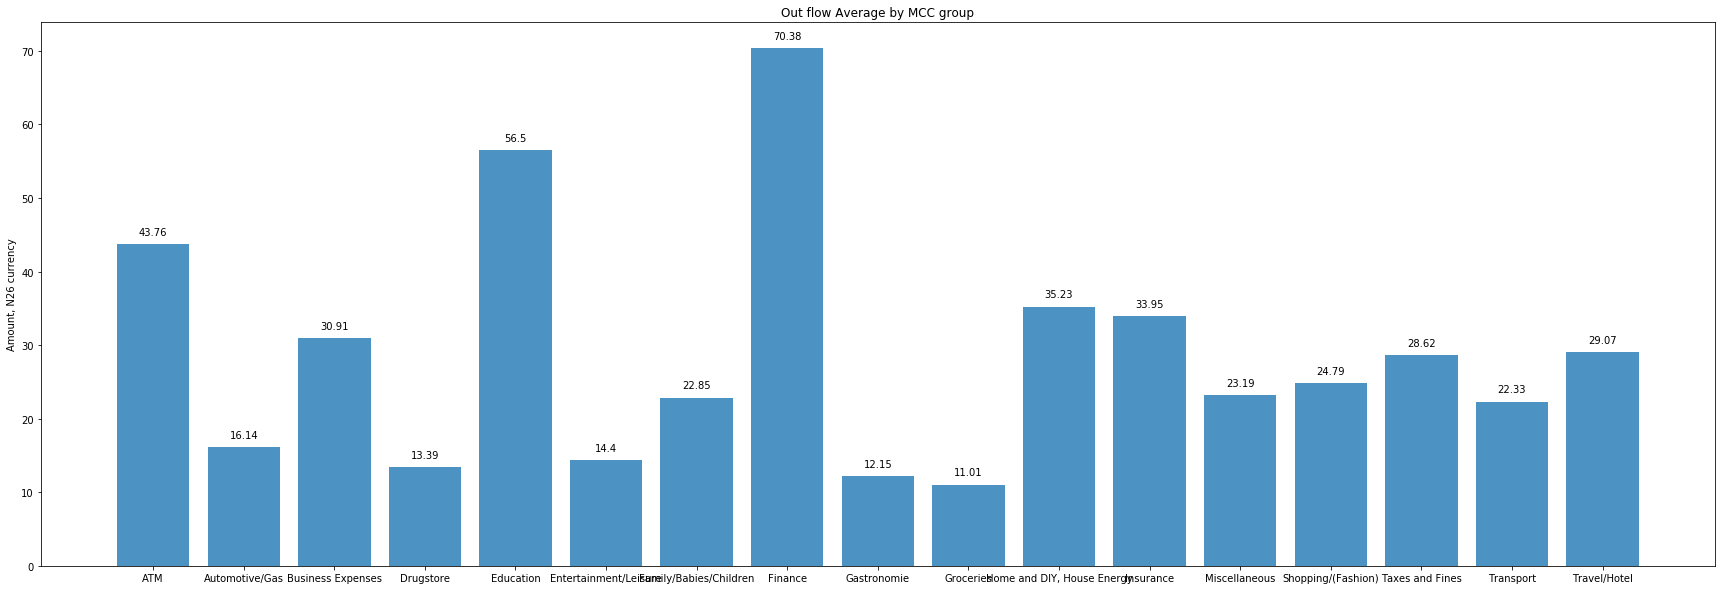

In [13]:
df = train_full.groupby(['expl_mcc', 'direction']).agg({'amount_n26_currency': 'mean'})
print(df)
df = df.reset_index()
  
fig, ax = plt.subplots( figsize=(30, 10))

ax.bar(df.loc[df['direction'] == 'Out', 'expl_mcc'], df.loc[df['direction'] == 'Out', 'amount_n26_currency'], alpha=0.8) 

ax.set_ylabel('Amount, N26 currency')
ax.set_title('Out flow Average by MCC group')

ax.set_xticklabels(df.loc[df['direction'] == 'Out', 'expl_mcc'])

rects = ax.patches
labels = df.loc[df['direction'] == 'Out', 'amount_n26_currency'].apply(lambda x: round(x, 2)).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 1, label, ha='center', va='bottom')

plt.show()

The most clients spent money for: 
1. Finance
2. Edication
3. ATM

### Continue Target varibale building
Because there is need to predict data for another month, there will be logically to aggregate transaction data by motnh. Next step performes this task:

In [14]:
train_agg = train_full.groupby(['user_id', 'month']).agg({'target': 'sum', 'transaction_type_BUB': 'sum', 'transaction_type_CT': 'sum',
       'transaction_type_DD': 'sum', 'transaction_type_DR': 'sum', 'transaction_type_DT': 'sum',
       'transaction_type_FT': 'sum', 'transaction_type_PT': 'sum', 'transaction_type_TUB': 'sum',
       'agent_Card': 'sum', 'agent_Partner': 'sum', 'mcc_group_2.0': 'sum', 'mcc_group_3.0': 'sum',
       'mcc_group_4.0': 'sum', 'mcc_group_5.0': 'sum',
       'mcc_group_6.0': 'sum', 'mcc_group_7.0': 'sum', 'mcc_group_8.0': 'sum', 'mcc_group_9.0': 'sum',
       'mcc_group_10.0': 'sum', 'mcc_group_11.0': 'sum', 'mcc_group_12.0': 'sum', 'mcc_group_13.0': 'sum',
       'mcc_group_14.0': 'sum', 'mcc_group_15.0': 'sum', 'mcc_group_16.0': 'sum', 'mcc_group_17.0': 'sum',
       'mcc_group_nan': 'sum'})
print(train_agg.columns.values)

['target' 'transaction_type_BUB' 'transaction_type_CT'
 'transaction_type_DD' 'transaction_type_DR' 'transaction_type_DT'
 'transaction_type_FT' 'transaction_type_PT' 'transaction_type_TUB'
 'agent_Card' 'agent_Partner' 'mcc_group_2.0' 'mcc_group_3.0'
 'mcc_group_4.0' 'mcc_group_5.0' 'mcc_group_6.0' 'mcc_group_7.0'
 'mcc_group_8.0' 'mcc_group_9.0' 'mcc_group_10.0' 'mcc_group_11.0'
 'mcc_group_12.0' 'mcc_group_13.0' 'mcc_group_14.0' 'mcc_group_15.0'
 'mcc_group_16.0' 'mcc_group_17.0' 'mcc_group_nan']


Now we will look at heat map of correlation between variables.

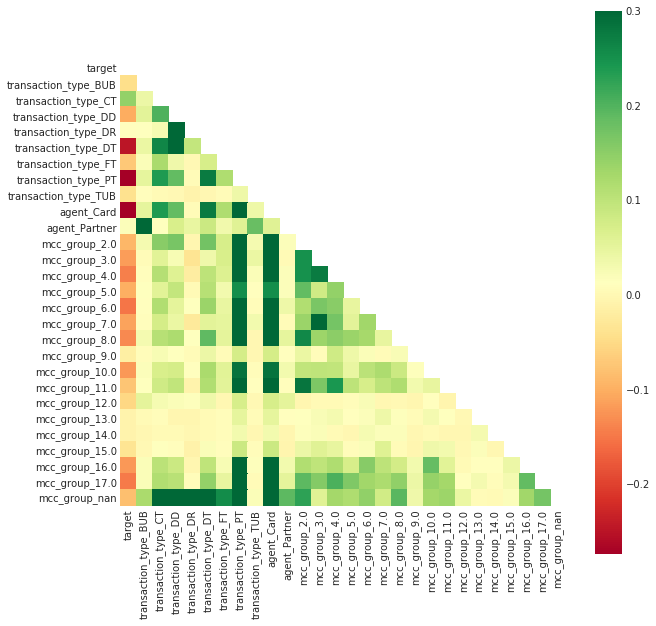

In [15]:
# Correlation plot
corr = train_agg.corr()
plt.figure(figsize=(10, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap='RdYlGn')
plt.show()

As we can see that correlation betwen target variable and other isn't very strong and ususaaly this connection is negative except *transaction_type_CT*. 

### Model building
When the data is ready I decided to use GradientBoosstingReggressor because we can use plusses of ensembling models.
To tune parameters were used 4-fold validation Randomized Search. After getting some boundaries of parameters grid using randomized search, I switched to Grid Search of parameters to get the best of them.

In [16]:
X = train_agg.drop('target', axis=1).values
y = train_agg['target'].values
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

'''
parameters = {'n_estimators': [100, 150, 200], 'max_depth': [4, 5, 6], 'min_samples_split': [30, 50, 100],
               'min_samples_leaf': [5, 10],
                  'learning_rate': [0.1], 'loss': ['ls'], 'subsample': [0.8, 0.9, 1.0]}
'''

# Optimal parameters
parameters = {'learning_rate': [0.1], 'loss': ['ls'], 'max_depth': [5], 'min_samples_leaf': [5],
              'min_samples_split': [30], 'n_estimators': [150], 'subsample': [1.0]}
n26_model = GradientBoostingRegressor()

#gs_n26_model = RandomizedSearchCV(n26_model, parameters, n_iter=200, n_jobs=-1, cv=4, verbose=2)
gs_n26_model = GridSearchCV(n26_model, parameters, n_jobs=-1, cv=4, verbose=2)

gs_n26_model = gs_n26_model.fit(X_train, y_train)

y_pred = gs_n26_model.predict(X_test)

print(gs_n26_model.best_params_)

print("MSE: %.4f" % mean_squared_error(y_test, y_pred))
print("Explained variance: %.4f" % explained_variance_score(y_test, y_pred))
print("R2: %.4f" % r2_score(y_test, y_pred))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.0s finished


{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 30, 'n_estimators': 150, 'subsample': 1.0}
MSE: 104072.7894
Explained variance: 0.3250
R2: 0.3250


Using estimated parameters we retrain model.

In [17]:
# Fit final regression model
params = gs_n26_model.best_params_
n26_model_fin = GradientBoostingRegressor(**params)

n26_model_fin.fit(X_train, y_train)
mse = mean_squared_error(y_test, n26_model_fin.predict(X_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_pred))
print("Explained variance: %.4f" % explained_variance_score(y_test, y_pred))
print("R2: %.4f" % r2_score(y_test, y_pred))

MSE: 104072.7894
Explained variance: 0.3250
R2: 0.3250


We have some estimation of MSE but let's look how loss function changed during model training on Traning Set and Test set.

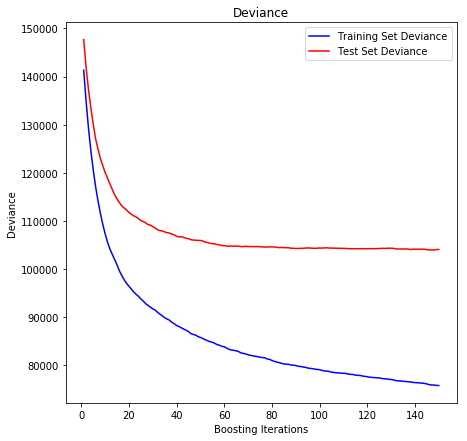

In [18]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(n26_model_fin.staged_predict(X_test)):
    test_score[i] = n26_model_fin.loss_(y_test, y_pred)

plt.figure(figsize=(7, 7))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, n26_model_fin.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

As we can see from the plot - with increase of number of boosting iterations train loss decreases but test loss doesn't. And difference between them is pretty high, so it looks like that built model has high variance.

Now let's plot variable importance.

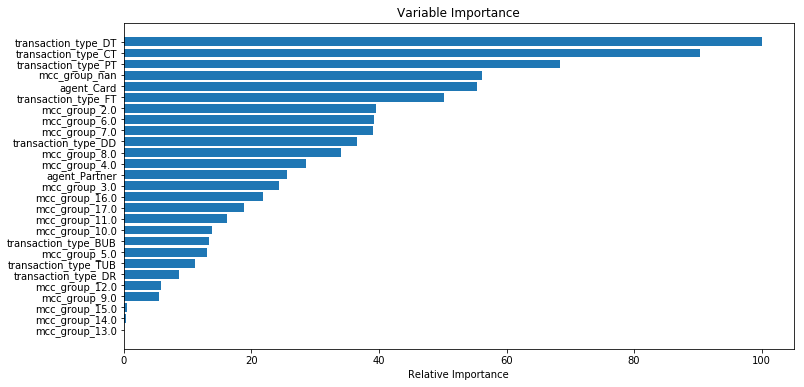

In [19]:
# Plot feature importance
vars = train_agg.columns.values[1:]
feature_importance = n26_model_fin.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, vars[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

This plots shows that most valuable values are 'Transaction Type - Debit Transfer', 'Transaction Type - Credit Transfer' and 'Agent Card'.

#### Results
Using provided data, was built model for predicting total profit/loss for client based on monthly data. For modelling was used Gradient Boosting Regressor. Parameters for regressor were found using 4-fold Grid Search. Further steps for imporiving model should address reducing variance so the model would be more robust on new data. 